In [1]:
%run env_setup.py
%matplotlib notebook

In [103]:
from importlib import reload
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import keras
from keras.layers import Dense, Conv2D, Flatten, UpSampling2D, BatchNormalization, Reshape, Activation, LeakyReLU
from keras.optimizers import Adam

# Origianl GAN

In [6]:
(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - ETA: 5: - ETA: 5: - ETA: 5: - ETA: 4: - ETA: 4: - ETA: 4: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 3: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 1: - ETA: 57s - ETA: 57 - ETA: 55 - ETA: 52 - ETA: 52 - ETA: 50 - ETA: 47 - ETA: 47 - ETA: 47 - ETA: 46 - ETA: 43 - ETA: 43 - ETA: 41 - ETA: 39 - ETA: 38 - ETA: 38 - ETA: 37 - ETA: 36 - ETA: 35 - ETA: 35 - ETA: 33 - ETA: 33 - ETA: 32 - ETA: 31 - ETA: 30 - ETA: 29 - ETA: 28 - ETA: 28 - ETA: 27 - ETA: 26 - ETA: 26 - ETA: 25 - ETA: 24 - ETA: 24 - ETA: 23 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 22 - ETA: 22 - ETA: 21 - ETA: 21 - ETA: 20 - ETA: 20 - ETA: 20 - ETA: 19 - ETA: 19 - ETA: 18 - ETA: 18 - ETA: 18 - ETA: 17 - ETA: 17 - ETA: 17 - ETA: 16 - ETA: 16 - ETA: 16 - ETA: 15 - ETA: 15 - ETA: 15 - ETA: 1

In [9]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [31]:
def noise(G, size):
    return np.random.rand(size, *G.input_shape[1:])

def set_trainable(model, trainable):
    model.trainable = trainable
    for l in model.layers:
        l.trainable = trainable
    #model.compile(model.optimizer, model.loss)

def train(D, G, loss_model, x, y, batch_size=128, epoches=5000):
    shuffle_idx = np.arange(len(x))
    np.random.shuffle(shuffle_idx)
    d_losses = []
    m_losses = []
    for e in tqdm(range(epoches)):
        start = (e * batch_size) % (len(x) - batch_size)
        idx = shuffle_idx[start: start + batch_size]
        # Generate data
        train_size = batch_size//2
        x_train = np.concatenate([x[idx[:train_size]], G.predict(noise(G, train_size))])
        y_train = np.array([0,]*train_size + [1,]*train_size)
        
        # train discriminator
        set_trainable(D, True)
        idx = np.arange(batch_size)
        np.random.shuffle(idx)
        d_losses.append(D.train_on_batch(x_train[idx], y_train[idx]))
        set_trainable(D, False)
        
        # train generator
        m_losses.append(loss_model.train_on_batch(noise(G, batch_size), np.zeros(batch_size)))
    return d_losses, m_losses

In [32]:
mlp_G = keras.Sequential([
    Dense(300, input_shape=(100,), activation='relu'),
    Dense(400, activation='relu'),
    Dense(np.prod(x_train.shape[1:]), activation='sigmoid'),
])
mlp_D = keras.Sequential([
    Dense(200, input_shape=(np.prod(x_train.shape[1:]),), activation='relu'),
    Dense(300, activation='relu'),
    Dense(1, activation='sigmoid'),
])
loss_model = keras.Sequential([mlp_G, mlp_D])
mlp_D.compile(Adam(lr=1e-4), 'binary_crossentropy')
loss_model.compile(Adam(lr=1e-4), 'binary_crossentropy')

In [33]:
d_loss, m_loss = train(mlp_D, mlp_G, loss_model,
                       x_train.reshape(len(x_train), -1).astype(np.float32)/255,
                       y_train.astype(np.float32))


  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]
D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:59<00:00, 83.99it/s]


<IPython.core.display.Javascript object>


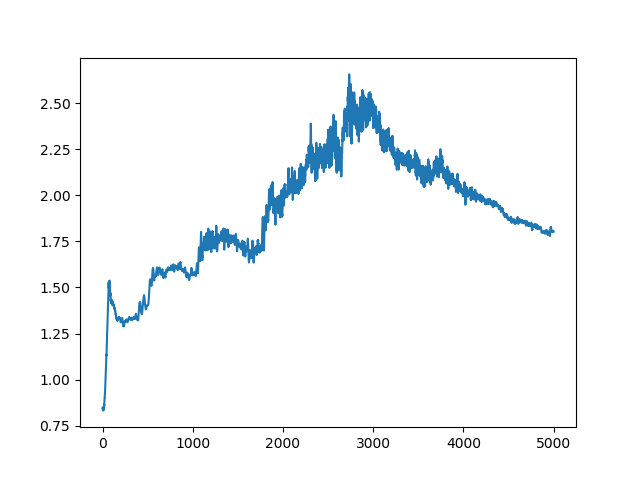

In [36]:
plt.plot(d_loss)

<IPython.core.display.Javascript object>


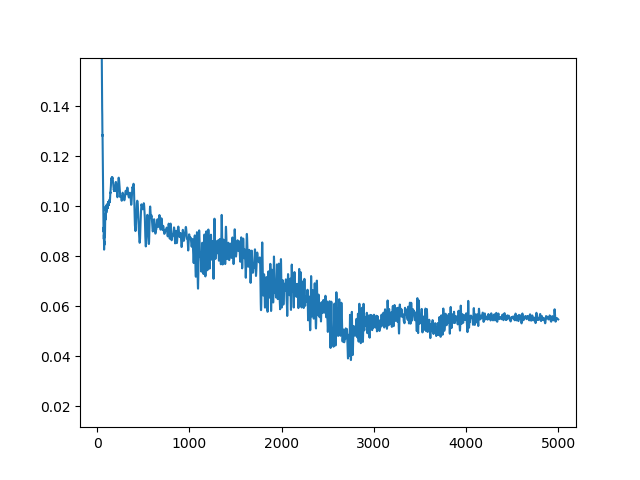

In [38]:
plt.plot(m_loss)

In [44]:
def plot_g(G, rows, cols):
    imgs = G.predict(noise(G, rows*cols)).reshape(rows, cols, *x_train.shape[1:])
    fig, axes = plt.subplots(rows, cols)
    for i, j in np.ndindex((rows, cols)):
        axes[i][j].imshow(imgs[i,j], cmap='gray')
    plt.show()

<IPython.core.display.Javascript object>


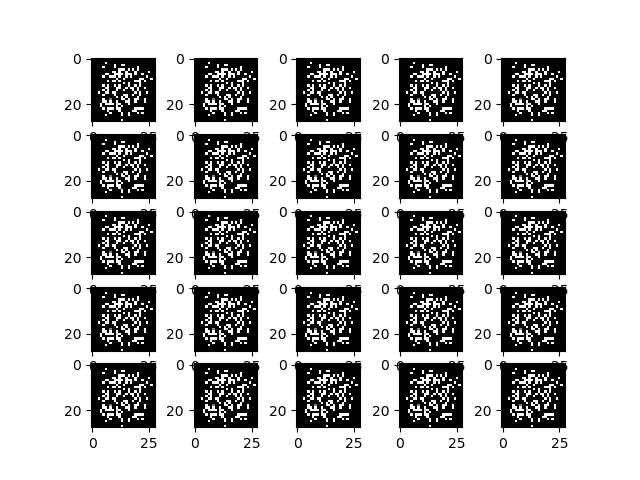

In [46]:
plot_g(mlp_G, 5,5)

# Using Y

In [52]:
num_classes = 11

def train(D, G, loss_model, x, y, batch_size=128, epoches=5000):
    shuffle_idx = np.arange(len(x))
    np.random.shuffle(shuffle_idx)
    d_losses = []
    m_losses = []
    for e in tqdm(range(epoches)):
        train_size = batch_size//2
        start = (e * train_size) % (len(x) - train_size)
        idx = shuffle_idx[start: start + train_size]
        # Generate data
        x_train = np.concatenate([x[idx], G.predict(noise(G, train_size))])
        y_train = [np.array([0,]*train_size + [1,]*train_size),
                  keras.utils.to_categorical(np.concatenate([y[idx], [num_classes-1]*train_size]), num_classes)]
        
        # train discriminator
        set_trainable(D, True)
        idx = np.arange(batch_size)
        np.random.shuffle(idx)
        d_losses.append(D.train_on_batch(x_train[idx], [a[idx] for a in y_train]))
        set_trainable(D, False)
        
        # train generator
        m_losses.append(loss_model.train_on_batch(noise(G, batch_size), np.zeros(batch_size)))
    return d_losses, m_losses

In [54]:
mlp_G = keras.Sequential([
    Dense(300, input_shape=(100,), activation='relu'),
    Dense(400, activation='relu'),
    Dense(np.prod(x_train.shape[1:]), activation='sigmoid'),
])
mlp_D = keras.Sequential([
    Dense(200, input_shape=(np.prod(x_train.shape[1:]),), activation='relu'),
    Dense(300, activation='relu'),
    Dense(1, activation='sigmoid'),
])
mlp_D_label = keras.Model(mlp_D.input, [mlp_D.output, Dense(11, activation='softmax')(mlp_D.layers[-2].output)])
loss_model = keras.Sequential([mlp_G, mlp_D])
mlp_D_label.compile(Adam(lr=1e-4), ['binary_crossentropy', 'categorical_crossentropy'])
loss_model.compile(Adam(lr=1e-4), 'binary_crossentropy')

In [55]:
d_loss, m_loss = train(mlp_D_label, mlp_G, loss_model,
                       x_train.reshape(len(x_train), -1).astype(np.float32)/255,
                       y_train.astype(np.float32))

  0%|                                                                                         | 0/5000 [00:00<?, ?it/s]D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [01:08<00:00, 73.12it/s]


<IPython.core.display.Javascript object>


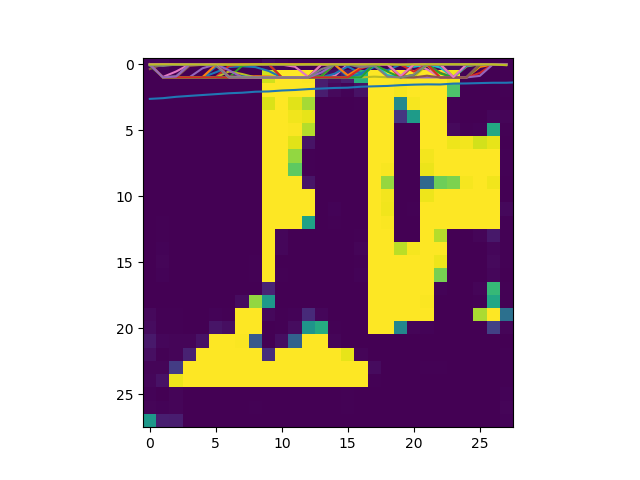

In [61]:
plt.plot([l[2] for l in d_loss])

<IPython.core.display.Javascript object>


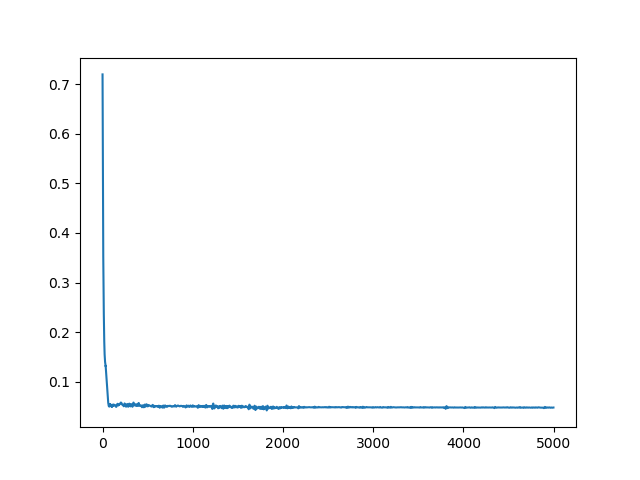

In [56]:
plt.plot(m_loss)

<IPython.core.display.Javascript object>


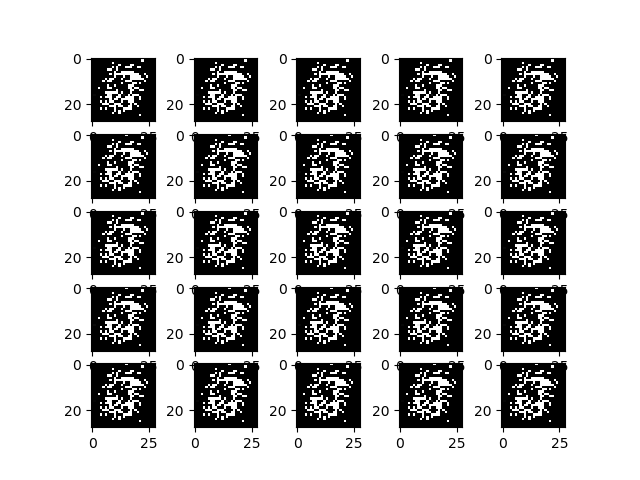

In [57]:
plot_g(mlp_G, 5,5)

# Use Convolution

In [107]:
img_size = x_train.shape[1:]
feature_size = (int(img_size[0]/4), int(img_size[1]/4))
dc_G_layers = [
    Dense(512*feature_size[0]*feature_size[1], input_shape=(100,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((feature_size[0], feature_size[1], 512))]
for kernal in (64, 32):
    dc_G_layers += [UpSampling2D(), Conv2D(kernal, (3, 3), padding='same'), BatchNormalization(), LeakyReLU()]
dc_G_layers.append(Conv2D(1, (1, 1), padding='same', activation='sigmoid'))

dc_G = keras.Sequential(dc_G_layers)
dc_G.summary()
dc_D = keras.Sequential([
    Conv2D(256, (5, 5), strides=2, padding='same', input_shape=img_size + (1,)),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(512, (5, 5), strides=2),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(256),
    LeakyReLU(),
    Dense(1, activation='sigmoid'),
])
dc_D.summary()
dc_D_label = keras.Model(dc_D.input, [dc_D.output, Dense(11, activation='softmax')(dc_D.layers[-2].output)])
loss_model = keras.Sequential([dc_G, dc_D])
dc_D_label.compile(Adam(lr=1e-4), ['binary_crossentropy', 'categorical_crossentropy'])
loss_model.compile(Adam(lr=1e-3), 'binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 25088)             2533888   
_________________________________________________________________
batch_normalization_31 (Batc (None, 25088)             100352    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 25088)             0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 7, 7, 512)         0         
_________________________________________________________________
up_sampling2d_21 (UpSampling (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 14, 14, 64)        294976    
_________________________________________________________________
batch_normalization_32 (Batc (None, 14, 14, 64)        256       
__________

D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\keras\activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 14, 14, 256)       6656      
_________________________________________________________________
batch_normalization_34 (Batc (None, 14, 14, 256)       1024      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 5, 5, 512)         3277312   
_________________________________________________________________
batch_normalization_35 (Batc (None, 5, 5, 512)         2048      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 5, 5, 512)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 12800)             0         
__________

In [108]:
d_loss, m_loss = train(dc_D_label, dc_G, loss_model,
                       x_train[..., None].astype(np.float32)/255,
                       y_train.astype(np.float32), batch_size=256, epoches=2500)


  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]
D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:39<00:00,  5.44it/s]


<IPython.core.display.Javascript object>


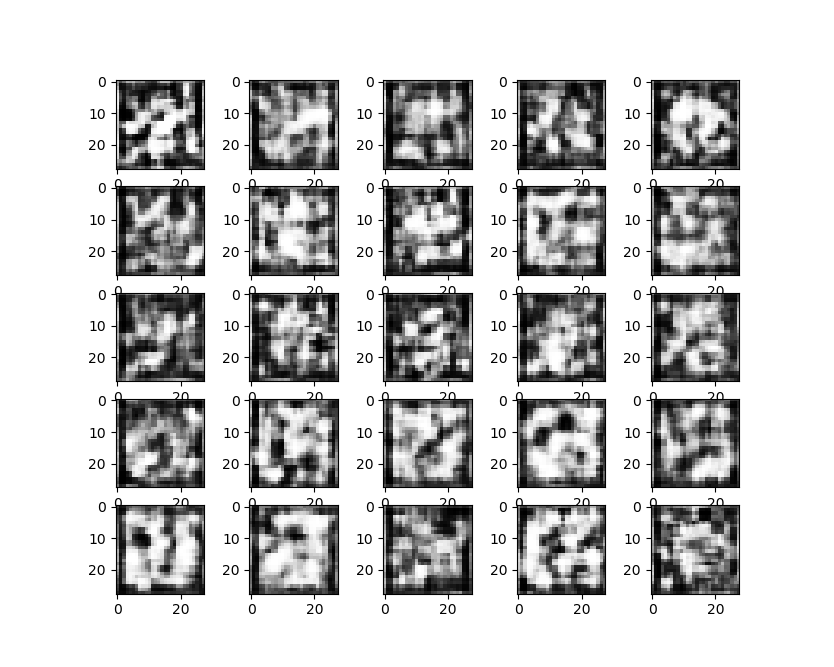

In [112]:
plot_g(dc_G, 5,5)

<IPython.core.display.Javascript object>


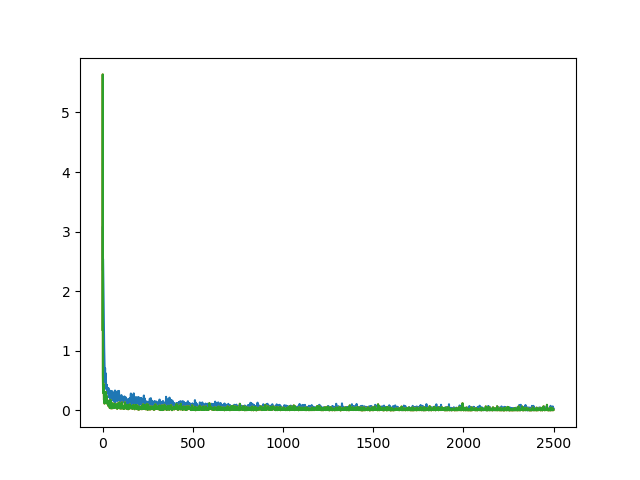

In [114]:
plt.plot([l[2] for l in d_loss])

<IPython.core.display.Javascript object>


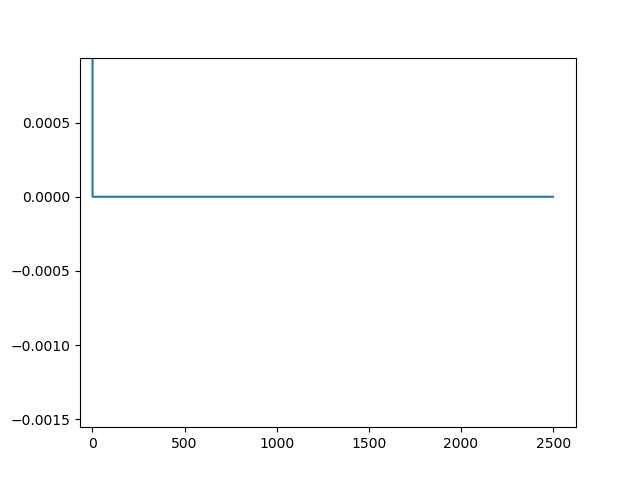

In [113]:
plt.plot(m_loss)

Generator always cheat
# Pretrain Discriminator

In [122]:
img_size = x_train.shape[1:]
feature_size = (int(img_size[0]/4), int(img_size[1]/4))
dc_G_layers = [
    Dense(512*feature_size[0]*feature_size[1], input_shape=(100,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((feature_size[0], feature_size[1], 512))]
for kernal in (64, 32):
    dc_G_layers += [UpSampling2D(), Conv2D(kernal, (3, 3), padding='same'), BatchNormalization(), LeakyReLU()]
dc_G_layers.append(Conv2D(1, (1, 1), padding='same', activation='sigmoid'))

dc_G = keras.Sequential(dc_G_layers)
dc_G.summary()
dc_D = keras.Sequential([
    Conv2D(256, (5, 5), strides=2, padding='same', input_shape=img_size + (1,)),
    BatchNormalization(),
    LeakyReLU(),
    Conv2D(512, (5, 5), strides=2),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(256),
    LeakyReLU(),
    Dense(1, activation='sigmoid'),
])
dc_D.summary()
dc_D_label = keras.Model(dc_D.input, [dc_D.output, Dense(11, activation='softmax')(dc_D.layers[-2].output)])
loss_model = keras.Sequential([dc_G, dc_D])
dc_D_label.compile(Adam(lr=1e-4), ['binary_crossentropy', 'categorical_crossentropy'])
loss_model.compile(Adam(lr=1e-3), 'binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 25088)             2533888   
_________________________________________________________________
batch_normalization_41 (Batc (None, 25088)             100352    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 25088)             0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 7, 7, 512)         0         
_________________________________________________________________
up_sampling2d_25 (UpSampling (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 14, 14, 64)        294976    
_________________________________________________________________
batch_normalization_42 (Batc (None, 14, 14, 64)        256       
__________

In [129]:
def prepare_data(x, y):
    x_pre = np.concatenate([x[..., None].astype(np.float32)/255, dc_G.predict(noise(dc_G, len(x)))])
    y_pre =  [np.array([0,]*len(x) + [1,]*len(x)),
              keras.utils.to_categorical(np.concatenate([y, [num_classes-1]*len(x)]), num_classes)]
    return x_pre, y_pre
x_pre, y_pre = prepare_data(x_train, y_train)
idx = np.arange(len(x_train))
np.random.shuffle(idx)
dc_D_label.fit(x_pre[idx], [a[idx] for a in y_pre], batch_size=256, epochs=5,
              validation_data=prepare_data(x_val, y_val))

Train on 60000 samples, validate on 20000 samples
Epoch 1/5


28672/60000 [=============>................] - ETA: 19:34 - loss: 3.4493 - dense_92_loss: 0.8303 - dense_93_loss: 2.61 - ETA: 9:52 - loss: 2.6601 - dense_92_loss: 0.4187 - dense_93_loss: 2.2414 - ETA: 6:37 - loss: 2.1738 - dense_92_loss: 0.2793 - dense_93_loss: 1.894 - ETA: 5:00 - loss: 1.8331 - dense_92_loss: 0.2095 - dense_93_loss: 1.623 - ETA: 4:02 - loss: 1.6034 - dense_92_loss: 0.1676 - dense_93_loss: 1.435 - ETA: 3:23 - loss: 1.4334 - dense_92_loss: 0.1397 - dense_93_loss: 1.293 - ETA: 2:55 - loss: 1.3169 - dense_92_loss: 0.1197 - dense_93_loss: 1.197 - ETA: 2:34 - loss: 1.2075 - dense_92_loss: 0.1048 - dense_93_loss: 1.102 - ETA: 2:18 - loss: 1.1190 - dense_92_loss: 0.0931 - dense_93_loss: 1.025 - ETA: 2:05 - loss: 1.0683 - dense_92_loss: 0.0838 - dense_93_loss: 0.984 - ETA: 1:54 - loss: 1.0167 - dense_92_loss: 0.0762 - dense_93_loss: 0.940 - ETA: 1:45 - loss: 0.9695 - dense_92_loss: 0.0699 - dense_93_loss: 0.899 - ETA: 1:38 - loss: 0.9284 - dense_92_loss: 0.0645 - dense_93_loss

57856/60000 [===========================>..] - ETA: 12s - loss: 0.3214 - dense_92_loss: 0.0074 - dense_93_loss: 0.31 - ETA: 12s - loss: 0.3197 - dense_92_loss: 0.0074 - dense_93_loss: 0.31 - ETA: 12s - loss: 0.3184 - dense_92_loss: 0.0073 - dense_93_loss: 0.31 - ETA: 12s - loss: 0.3165 - dense_92_loss: 0.0072 - dense_93_loss: 0.30 - ETA: 12s - loss: 0.3152 - dense_92_loss: 0.0072 - dense_93_loss: 0.30 - ETA: 12s - loss: 0.3137 - dense_92_loss: 0.0071 - dense_93_loss: 0.30 - ETA: 11s - loss: 0.3122 - dense_92_loss: 0.0070 - dense_93_loss: 0.30 - ETA: 11s - loss: 0.3107 - dense_92_loss: 0.0070 - dense_93_loss: 0.30 - ETA: 11s - loss: 0.3096 - dense_92_loss: 0.0069 - dense_93_loss: 0.30 - ETA: 11s - loss: 0.3080 - dense_92_loss: 0.0069 - dense_93_loss: 0.30 - ETA: 11s - loss: 0.3069 - dense_92_loss: 0.0068 - dense_93_loss: 0.30 - ETA: 11s - loss: 0.3055 - dense_92_loss: 0.0068 - dense_93_loss: 0.29 - ETA: 11s - loss: 0.3045 - dense_92_loss: 0.0067 - dense_93_loss: 0.29 - ETA: 10s - loss: 

60000/60000 [==============================] - ETA: 0s - loss: 0.2254 - dense_92_loss: 0.0037 - dense_93_loss: 0.221 - ETA: 0s - loss: 0.2247 - dense_92_loss: 0.0037 - dense_93_loss: 0.221 - ETA: 0s - loss: 0.2241 - dense_92_loss: 0.0037 - dense_93_loss: 0.220 - ETA: 0s - loss: 0.2236 - dense_92_loss: 0.0037 - dense_93_loss: 0.219 - ETA: 0s - loss: 0.2232 - dense_92_loss: 0.0036 - dense_93_loss: 0.219 - ETA: 0s - loss: 0.2226 - dense_92_loss: 0.0036 - dense_93_loss: 0.218 - ETA: 0s - loss: 0.2220 - dense_92_loss: 0.0036 - dense_93_loss: 0.218 - ETA: 0s - loss: 0.2214 - dense_92_loss: 0.0036 - dense_93_loss: 0.217 - 21s 349us/step - loss: 0.2213 - dense_92_loss: 0.0036 - dense_93_loss: 0.2177 - val_loss: 2.4495 - val_dense_92_loss: 1.0748 - val_dense_93_loss: 1.3747
Epoch 2/5


27648/60000 [============>.................] - ETA: 13s - loss: 0.1293 - dense_92_loss: 3.9767e-06 - dense_93_loss: 0.12 - ETA: 13s - loss: 0.1222 - dense_92_loss: 5.8396e-06 - dense_93_loss: 0.12 - ETA: 13s - loss: 0.1017 - dense_92_loss: 5.9423e-06 - dense_93_loss: 0.10 - ETA: 13s - loss: 0.0966 - dense_92_loss: 5.4885e-06 - dense_93_loss: 0.09 - ETA: 13s - loss: 0.0931 - dense_92_loss: 5.5093e-06 - dense_93_loss: 0.09 - ETA: 13s - loss: 0.0891 - dense_92_loss: 4.9969e-06 - dense_93_loss: 0.08 - ETA: 13s - loss: 0.0869 - dense_92_loss: 4.9646e-06 - dense_93_loss: 0.08 - ETA: 13s - loss: 0.0884 - dense_92_loss: 9.4238e-06 - dense_93_loss: 0.08 - ETA: 13s - loss: 0.0903 - dense_92_loss: 8.5516e-06 - dense_93_loss: 0.09 - ETA: 13s - loss: 0.0893 - dense_92_loss: 8.4681e-06 - dense_93_loss: 0.08 - ETA: 13s - loss: 0.0904 - dense_92_loss: 8.2321e-06 - dense_93_loss: 0.09 - ETA: 13s - loss: 0.0862 - dense_92_loss: 9.3808e-06 - dense_93_loss: 0.08 - ETA: 13s - loss: 0.0849 - dense_92_loss: 

55296/60000 [==========================>...] - ETA: 7s - loss: 0.0770 - dense_92_loss: 1.7838e-05 - dense_93_loss: 0.077 - ETA: 7s - loss: 0.0767 - dense_92_loss: 1.7901e-05 - dense_93_loss: 0.076 - ETA: 7s - loss: 0.0766 - dense_92_loss: 1.7890e-05 - dense_93_loss: 0.076 - ETA: 7s - loss: 0.0766 - dense_92_loss: 1.7750e-05 - dense_93_loss: 0.076 - ETA: 7s - loss: 0.0766 - dense_92_loss: 1.7815e-05 - dense_93_loss: 0.076 - ETA: 7s - loss: 0.0766 - dense_92_loss: 1.7691e-05 - dense_93_loss: 0.076 - ETA: 7s - loss: 0.0763 - dense_92_loss: 1.7927e-05 - dense_93_loss: 0.076 - ETA: 7s - loss: 0.0762 - dense_92_loss: 1.7818e-05 - dense_93_loss: 0.076 - ETA: 7s - loss: 0.0763 - dense_92_loss: 1.7751e-05 - dense_93_loss: 0.076 - ETA: 7s - loss: 0.0760 - dense_92_loss: 1.7652e-05 - dense_93_loss: 0.075 - ETA: 7s - loss: 0.0761 - dense_92_loss: 1.7581e-05 - dense_93_loss: 0.076 - ETA: 6s - loss: 0.0759 - dense_92_loss: 1.7502e-05 - dense_93_loss: 0.075 - ETA: 6s - loss: 0.0757 - dense_92_loss: 1

60000/60000 [==============================] - ETA: 1s - loss: 0.0718 - dense_92_loss: 2.5151e-05 - dense_93_loss: 0.071 - ETA: 1s - loss: 0.0718 - dense_92_loss: 2.5067e-05 - dense_93_loss: 0.071 - ETA: 0s - loss: 0.0720 - dense_92_loss: 2.5096e-05 - dense_93_loss: 0.071 - ETA: 0s - loss: 0.0722 - dense_92_loss: 2.5020e-05 - dense_93_loss: 0.072 - ETA: 0s - loss: 0.0720 - dense_92_loss: 2.4945e-05 - dense_93_loss: 0.072 - ETA: 0s - loss: 0.0720 - dense_92_loss: 2.4857e-05 - dense_93_loss: 0.072 - ETA: 0s - loss: 0.0722 - dense_92_loss: 2.4759e-05 - dense_93_loss: 0.072 - ETA: 0s - loss: 0.0721 - dense_92_loss: 2.4667e-05 - dense_93_loss: 0.072 - ETA: 0s - loss: 0.0719 - dense_92_loss: 2.4600e-05 - dense_93_loss: 0.071 - ETA: 0s - loss: 0.0720 - dense_92_loss: 2.4534e-05 - dense_93_loss: 0.071 - ETA: 0s - loss: 0.0718 - dense_92_loss: 2.4692e-05 - dense_93_loss: 0.071 - ETA: 0s - loss: 0.0717 - dense_92_loss: 2.4636e-05 - dense_93_loss: 0.071 - ETA: 0s - loss: 0.0715 - dense_92_loss: 2

27648/60000 [============>.................] - ETA: 13s - loss: 0.0326 - dense_92_loss: 1.0027e-05 - dense_93_loss: 0.03 - ETA: 13s - loss: 0.0318 - dense_92_loss: 1.3296e-05 - dense_93_loss: 0.03 - ETA: 13s - loss: 0.0318 - dense_92_loss: 1.1555e-05 - dense_93_loss: 0.03 - ETA: 13s - loss: 0.0393 - dense_92_loss: 1.0279e-05 - dense_93_loss: 0.03 - ETA: 13s - loss: 0.0411 - dense_92_loss: 1.5297e-05 - dense_93_loss: 0.04 - ETA: 13s - loss: 0.0476 - dense_92_loss: 1.4683e-05 - dense_93_loss: 0.04 - ETA: 13s - loss: 0.0519 - dense_92_loss: 1.8656e-05 - dense_93_loss: 0.05 - ETA: 13s - loss: 0.0519 - dense_92_loss: 1.7477e-05 - dense_93_loss: 0.05 - ETA: 13s - loss: 0.0500 - dense_92_loss: 1.6419e-05 - dense_93_loss: 0.05 - ETA: 13s - loss: 0.0499 - dense_92_loss: 1.8088e-05 - dense_93_loss: 0.04 - ETA: 13s - loss: 0.0540 - dense_92_loss: 1.9583e-05 - dense_93_loss: 0.05 - ETA: 13s - loss: 0.0514 - dense_92_loss: 1.8768e-05 - dense_93_loss: 0.05 - ETA: 13s - loss: 0.0494 - dense_92_loss: 

55296/60000 [==========================>...] - ETA: 7s - loss: 0.0466 - dense_92_loss: 1.7335e-05 - dense_93_loss: 0.046 - ETA: 7s - loss: 0.0464 - dense_92_loss: 1.7222e-05 - dense_93_loss: 0.046 - ETA: 7s - loss: 0.0464 - dense_92_loss: 1.7098e-05 - dense_93_loss: 0.046 - ETA: 7s - loss: 0.0465 - dense_92_loss: 1.6997e-05 - dense_93_loss: 0.046 - ETA: 7s - loss: 0.0466 - dense_92_loss: 1.6880e-05 - dense_93_loss: 0.046 - ETA: 7s - loss: 0.0467 - dense_92_loss: 1.6786e-05 - dense_93_loss: 0.046 - ETA: 7s - loss: 0.0465 - dense_92_loss: 1.6811e-05 - dense_93_loss: 0.046 - ETA: 7s - loss: 0.0464 - dense_92_loss: 1.6809e-05 - dense_93_loss: 0.046 - ETA: 7s - loss: 0.0463 - dense_92_loss: 1.6807e-05 - dense_93_loss: 0.046 - ETA: 7s - loss: 0.0463 - dense_92_loss: 1.6751e-05 - dense_93_loss: 0.046 - ETA: 7s - loss: 0.0461 - dense_92_loss: 1.6669e-05 - dense_93_loss: 0.046 - ETA: 7s - loss: 0.0461 - dense_92_loss: 1.6750e-05 - dense_93_loss: 0.046 - ETA: 6s - loss: 0.0460 - dense_92_loss: 1

60000/60000 [==============================] - ETA: 1s - loss: 0.0489 - dense_92_loss: 2.0322e-05 - dense_93_loss: 0.048 - ETA: 1s - loss: 0.0490 - dense_92_loss: 2.0267e-05 - dense_93_loss: 0.049 - ETA: 0s - loss: 0.0492 - dense_92_loss: 2.0278e-05 - dense_93_loss: 0.049 - ETA: 0s - loss: 0.0493 - dense_92_loss: 2.0270e-05 - dense_93_loss: 0.049 - ETA: 0s - loss: 0.0492 - dense_92_loss: 2.0247e-05 - dense_93_loss: 0.049 - ETA: 0s - loss: 0.0492 - dense_92_loss: 2.0201e-05 - dense_93_loss: 0.049 - ETA: 0s - loss: 0.0492 - dense_92_loss: 2.0203e-05 - dense_93_loss: 0.049 - ETA: 0s - loss: 0.0492 - dense_92_loss: 2.0164e-05 - dense_93_loss: 0.049 - ETA: 0s - loss: 0.0490 - dense_92_loss: 2.0121e-05 - dense_93_loss: 0.049 - ETA: 0s - loss: 0.0490 - dense_92_loss: 2.0104e-05 - dense_93_loss: 0.048 - ETA: 0s - loss: 0.0488 - dense_92_loss: 2.0054e-05 - dense_93_loss: 0.048 - ETA: 0s - loss: 0.0487 - dense_92_loss: 2.0015e-05 - dense_93_loss: 0.048 - ETA: 0s - loss: 0.0486 - dense_92_loss: 1

27648/60000 [============>.................] - ETA: 13s - loss: 0.0621 - dense_92_loss: 1.4092e-05 - dense_93_loss: 0.06 - ETA: 13s - loss: 0.0575 - dense_92_loss: 3.0927e-05 - dense_93_loss: 0.05 - ETA: 14s - loss: 0.0467 - dense_92_loss: 3.0356e-05 - dense_93_loss: 0.04 - ETA: 14s - loss: 0.0475 - dense_92_loss: 2.6491e-05 - dense_93_loss: 0.04 - ETA: 13s - loss: 0.0458 - dense_92_loss: 2.4718e-05 - dense_93_loss: 0.04 - ETA: 14s - loss: 0.0462 - dense_92_loss: 2.5539e-05 - dense_93_loss: 0.04 - ETA: 14s - loss: 0.0446 - dense_92_loss: 2.4909e-05 - dense_93_loss: 0.04 - ETA: 13s - loss: 0.0428 - dense_92_loss: 2.4079e-05 - dense_93_loss: 0.04 - ETA: 13s - loss: 0.0446 - dense_92_loss: 2.2410e-05 - dense_93_loss: 0.04 - ETA: 13s - loss: 0.0444 - dense_92_loss: 2.1198e-05 - dense_93_loss: 0.04 - ETA: 13s - loss: 0.0434 - dense_92_loss: 2.0087e-05 - dense_93_loss: 0.04 - ETA: 13s - loss: 0.0415 - dense_92_loss: 1.9163e-05 - dense_93_loss: 0.04 - ETA: 13s - loss: 0.0395 - dense_92_loss: 

55296/60000 [==========================>...] - ETA: 7s - loss: 0.0318 - dense_92_loss: 2.0293e-05 - dense_93_loss: 0.031 - ETA: 7s - loss: 0.0320 - dense_92_loss: 2.0227e-05 - dense_93_loss: 0.032 - ETA: 7s - loss: 0.0323 - dense_92_loss: 2.0120e-05 - dense_93_loss: 0.032 - ETA: 7s - loss: 0.0321 - dense_92_loss: 2.0224e-05 - dense_93_loss: 0.032 - ETA: 7s - loss: 0.0320 - dense_92_loss: 2.0104e-05 - dense_93_loss: 0.032 - ETA: 7s - loss: 0.0319 - dense_92_loss: 2.0002e-05 - dense_93_loss: 0.031 - ETA: 7s - loss: 0.0321 - dense_92_loss: 1.9887e-05 - dense_93_loss: 0.032 - ETA: 7s - loss: 0.0321 - dense_92_loss: 1.9890e-05 - dense_93_loss: 0.032 - ETA: 7s - loss: 0.0320 - dense_92_loss: 1.9785e-05 - dense_93_loss: 0.032 - ETA: 7s - loss: 0.0321 - dense_92_loss: 1.9652e-05 - dense_93_loss: 0.032 - ETA: 7s - loss: 0.0319 - dense_92_loss: 1.9625e-05 - dense_93_loss: 0.031 - ETA: 7s - loss: 0.0319 - dense_92_loss: 2.0039e-05 - dense_93_loss: 0.031 - ETA: 6s - loss: 0.0319 - dense_92_loss: 2

60000/60000 [==============================] - ETA: 1s - loss: 0.0337 - dense_92_loss: 1.9949e-05 - dense_93_loss: 0.033 - ETA: 0s - loss: 0.0339 - dense_92_loss: 1.9928e-05 - dense_93_loss: 0.033 - ETA: 0s - loss: 0.0340 - dense_92_loss: 1.9923e-05 - dense_93_loss: 0.034 - ETA: 0s - loss: 0.0342 - dense_92_loss: 1.9974e-05 - dense_93_loss: 0.034 - ETA: 0s - loss: 0.0341 - dense_92_loss: 1.9952e-05 - dense_93_loss: 0.034 - ETA: 0s - loss: 0.0341 - dense_92_loss: 1.9900e-05 - dense_93_loss: 0.034 - ETA: 0s - loss: 0.0340 - dense_92_loss: 1.9852e-05 - dense_93_loss: 0.034 - ETA: 0s - loss: 0.0341 - dense_92_loss: 1.9815e-05 - dense_93_loss: 0.034 - ETA: 0s - loss: 0.0342 - dense_92_loss: 1.9777e-05 - dense_93_loss: 0.034 - ETA: 0s - loss: 0.0342 - dense_92_loss: 1.9742e-05 - dense_93_loss: 0.034 - ETA: 0s - loss: 0.0343 - dense_92_loss: 1.9736e-05 - dense_93_loss: 0.034 - ETA: 0s - loss: 0.0342 - dense_92_loss: 1.9698e-05 - dense_93_loss: 0.034 - ETA: 0s - loss: 0.0342 - dense_92_loss: 1

27648/60000 [============>.................] - ETA: 13s - loss: 0.0319 - dense_92_loss: 3.2755e-05 - dense_93_loss: 0.03 - ETA: 13s - loss: 0.0249 - dense_92_loss: 2.3888e-05 - dense_93_loss: 0.02 - ETA: 13s - loss: 0.0208 - dense_92_loss: 2.0010e-05 - dense_93_loss: 0.02 - ETA: 14s - loss: 0.0226 - dense_92_loss: 1.8430e-05 - dense_93_loss: 0.02 - ETA: 13s - loss: 0.0220 - dense_92_loss: 1.9873e-05 - dense_93_loss: 0.02 - ETA: 13s - loss: 0.0210 - dense_92_loss: 2.1175e-05 - dense_93_loss: 0.02 - ETA: 13s - loss: 0.0211 - dense_92_loss: 1.9161e-05 - dense_93_loss: 0.02 - ETA: 13s - loss: 0.0228 - dense_92_loss: 1.9997e-05 - dense_93_loss: 0.02 - ETA: 13s - loss: 0.0223 - dense_92_loss: 1.9572e-05 - dense_93_loss: 0.02 - ETA: 13s - loss: 0.0243 - dense_92_loss: 1.9344e-05 - dense_93_loss: 0.02 - ETA: 13s - loss: 0.0234 - dense_92_loss: 1.9657e-05 - dense_93_loss: 0.02 - ETA: 13s - loss: 0.0228 - dense_92_loss: 2.1555e-05 - dense_93_loss: 0.02 - ETA: 13s - loss: 0.0229 - dense_92_loss: 

55296/60000 [==========================>...] - ETA: 7s - loss: 0.0231 - dense_92_loss: 2.2128e-05 - dense_93_loss: 0.023 - ETA: 7s - loss: 0.0230 - dense_92_loss: 2.2129e-05 - dense_93_loss: 0.023 - ETA: 7s - loss: 0.0235 - dense_92_loss: 2.2040e-05 - dense_93_loss: 0.023 - ETA: 7s - loss: 0.0235 - dense_92_loss: 2.1933e-05 - dense_93_loss: 0.023 - ETA: 7s - loss: 0.0236 - dense_92_loss: 2.2088e-05 - dense_93_loss: 0.023 - ETA: 7s - loss: 0.0234 - dense_92_loss: 2.1950e-05 - dense_93_loss: 0.023 - ETA: 7s - loss: 0.0233 - dense_92_loss: 2.1860e-05 - dense_93_loss: 0.023 - ETA: 7s - loss: 0.0234 - dense_92_loss: 2.1728e-05 - dense_93_loss: 0.023 - ETA: 7s - loss: 0.0235 - dense_92_loss: 2.1631e-05 - dense_93_loss: 0.023 - ETA: 7s - loss: 0.0233 - dense_92_loss: 2.1554e-05 - dense_93_loss: 0.023 - ETA: 7s - loss: 0.0234 - dense_92_loss: 2.1808e-05 - dense_93_loss: 0.023 - ETA: 7s - loss: 0.0233 - dense_92_loss: 2.1728e-05 - dense_93_loss: 0.023 - ETA: 6s - loss: 0.0232 - dense_92_loss: 2

60000/60000 [==============================] - ETA: 1s - loss: 0.0243 - dense_92_loss: 2.1651e-05 - dense_93_loss: 0.024 - ETA: 1s - loss: 0.0243 - dense_92_loss: 2.1600e-05 - dense_93_loss: 0.024 - ETA: 0s - loss: 0.0243 - dense_92_loss: 2.1556e-05 - dense_93_loss: 0.024 - ETA: 0s - loss: 0.0244 - dense_92_loss: 2.1519e-05 - dense_93_loss: 0.024 - ETA: 0s - loss: 0.0244 - dense_92_loss: 2.1453e-05 - dense_93_loss: 0.024 - ETA: 0s - loss: 0.0245 - dense_92_loss: 2.1445e-05 - dense_93_loss: 0.024 - ETA: 0s - loss: 0.0246 - dense_92_loss: 2.1408e-05 - dense_93_loss: 0.024 - ETA: 0s - loss: 0.0246 - dense_92_loss: 2.1351e-05 - dense_93_loss: 0.024 - ETA: 0s - loss: 0.0247 - dense_92_loss: 2.1288e-05 - dense_93_loss: 0.024 - ETA: 0s - loss: 0.0247 - dense_92_loss: 2.1242e-05 - dense_93_loss: 0.024 - ETA: 0s - loss: 0.0247 - dense_92_loss: 2.1547e-05 - dense_93_loss: 0.024 - ETA: 0s - loss: 0.0247 - dense_92_loss: 2.1513e-05 - dense_93_loss: 0.024 - ETA: 0s - loss: 0.0247 - dense_92_loss: 2

In [130]:
d_loss, m_loss = train(dc_D_label, dc_G, loss_model,
                       x_train[..., None].astype(np.float32)/255,
                       y_train.astype(np.float32), batch_size=256, epoches=2500)

  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]D:\dev\libs\Anaconda3\envs\tf140p35\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [07:31<00:00,  5.53it/s]


<IPython.core.display.Javascript object>


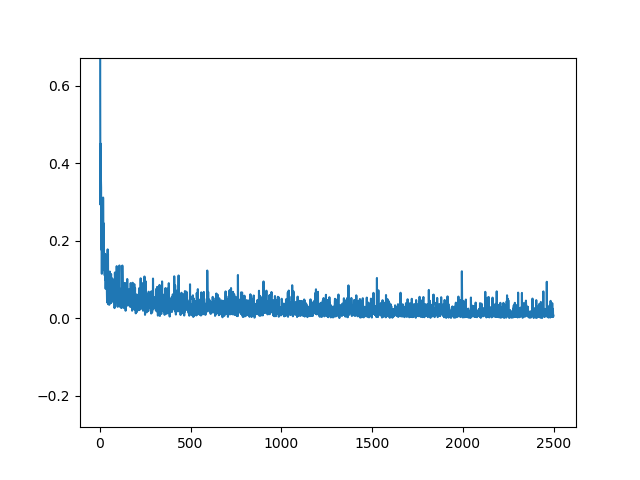

In [134]:
plt.plot([l[2] for l in d_loss])

<IPython.core.display.Javascript object>


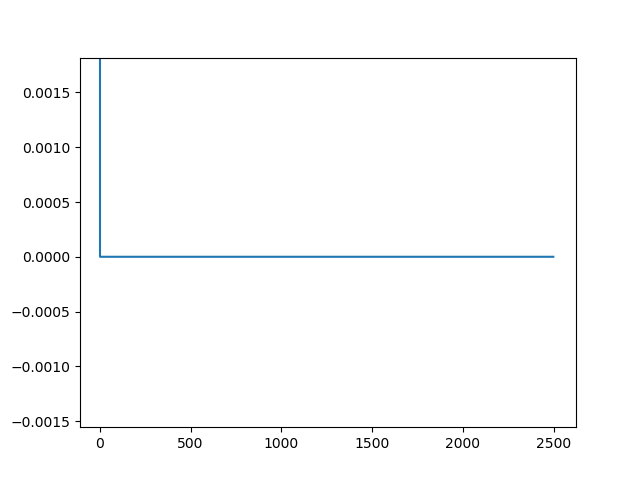

In [135]:
plt.plot(m_loss)

<IPython.core.display.Javascript object>


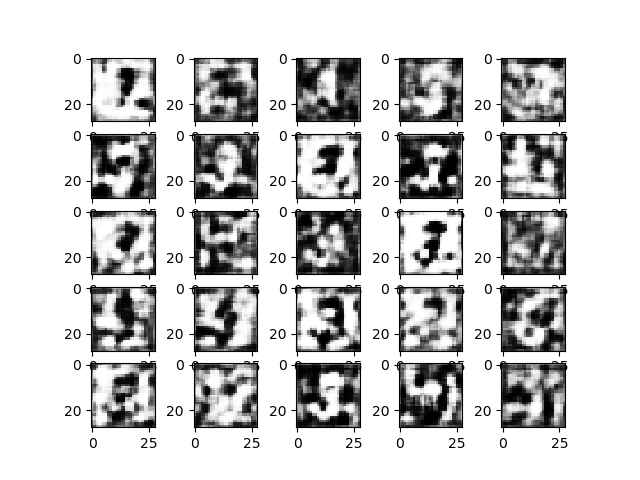

In [136]:
plot_g(dc_G, 5,5)